In [1]:
import sys, warnings
import itertools as it

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import torch
tt =  torch.tensor
import pyro
from pyro.distributions import Bernoulli, Binomial, Delta, Exponential, Normal
from pyro.infer import Predictive
from pyro.ops.stats import hpdi, waic
import arviz as az
import seaborn as sns
from utils import plot_errorbar, train_nuts, traceplot, unnest_samples, plot_intervals

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Sep 19 2024

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.18.1

pandas    : 2.2.2
sys       : 3.9.19 (main, May  6 2024, 19:43:03) 
[GCC 11.2.0]
arviz     : 0.17.1
numpy     : 1.26.4
torch     : 2.3.0
pyro      : 1.9.1
seaborn   : 0.12.2
scipy     : 1.12.0
matplotlib: 3.9.0

Watermark: 2.4.3



Finally, we get to hierarchical models. I've been looking forward to this chapter for a while now. Hierarchical (or multilevel) models basically use data at multiple different levels of granularity to squeeze as much statistical power out as possible. For example, if you want to measure the waiting time at multiple cafes, then you can either
1. Measure the average waiting time of each separately
2. Measure the average waiting time of all of them together
3. Use the distribution of all waiting times as the prior, then learn a posterior distribution for each cafe

Options 1 and 2 are sub-optimal, because in option 1, learning something about the waiting times of one cafe does nothing to help you learn the waiting times at other cafes. They're likely to be at least somewhat similar to each other, right? In option 2, you'll get the same output for every cafe. But each one has some degree of variation, right? Option 3 allows you to combine both 1 & 2 to get the best of both worlds.

### Code 13.1 - 13.6
We will use a dataset on the life cycle of tadpoles as our first foray into multilevel models.

In [3]:
tadpole_df = pd.read_csv("data/reedfrogs.csv", sep=";")
N_TANKS = len(tadpole_df)
print(N_TANKS, "rows")
tadpole_df.head()

48 rows


,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9


In [4]:
data = {
    "tank": tt(tadpole_df.index.values).long(),
    "S": tt(tadpole_df["surv"].values).double(),
    "N": tt(tadpole_df["density"].values).long(),
}

First we will do a simple model that just considers each tank separately.

$$\begin{align*}
S_i &\sim \text{Binomial}(N_i, p_i) \\
p_i &= \sigma(\alpha_\text{tank[i]}) \\
\alpha_j &\sim \text{Normal}(0, \sigma_{param});\qquad j=0,\cdots,47
\end{align*}$$

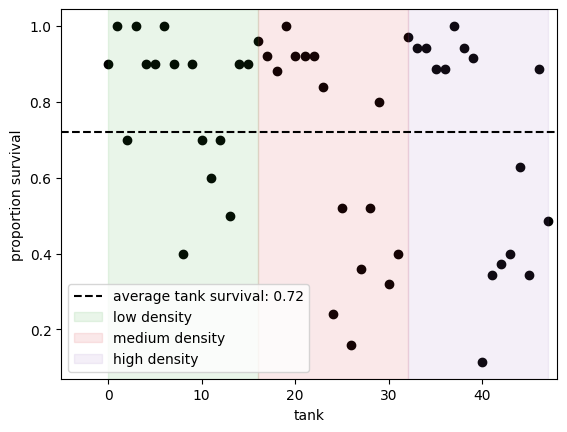

In [5]:
plt.scatter(tadpole_df.index, tadpole_df.propsurv, color='k')

# Plot average survival rate across tanks
global_mean = tadpole_df.propsurv.mean()
plt.axhline(global_mean, color='k', linestyle='--', label=f"average tank survival: {global_mean:1.2}")

# Highlight different densities
density_change = tadpole_df[tadpole_df.density.diff() > 0].index.tolist()
density_change.append(N_TANKS-1)
start = 0
density_labels = ['low', 'medium', 'high']
for ii in range(3):
    end = density_change[ii]
    plt.axvspan(start, end, alpha=.1, label=f"{density_labels[ii]} density", color=f'C{ii+2}')
    start = end

plt.xlabel("tank")
plt.xlim([-5, N_TANKS])
plt.ylabel("proportion survival")
plt.legend();

In [6]:
def plot_tank(model, colors="red", hdi_prob=0.89, alpha=0.25, error_width=6):
    samples = model.get_samples()
    df = tadpole_df#.sort_values("density")
    x = df.index.values
    y = df["propsurv"].values
    if isinstance(colors, str):
        colors = [colors] * len(x)
    plt.scatter(x, y, color="C0", label="data")
    y = torch.sigmoid(samples["a"][:,x])
    plt.scatter(x, y.mean(axis=0), facecolor="none", edgecolor="black", label="inferred")
    h = hpdi(y, hdi_prob, 0)
    #h = az.hdi(y.numpy(), hdi_prob=hdi_prob)
    posterior_mean = y.mean(axis=0)
    h_offset = (h - posterior_mean).abs()
    plot_errorbar(xs=range(len(posterior_mean)), ys=posterior_mean, colors=colors,
                  error_lower=h_offset[0,:], error_upper=h_offset[1,:], error_width=error_width, alpha=alpha)
    for i in range(4):
        plt.axvline(16*i-0.5, color="black", linewidth=1)
    plt.xlabel("tank index")
    plt.ylabel(r"survival probability $p$")
    plt.text(8, 0.01, "small tank", horizontalalignment="center")
    plt.text(24, 0.01, "medium tank", horizontalalignment="center")
    plt.text(40, 0.01, "large tank", horizontalalignment="center")
    plt.ylim(bottom=0)
    plt.title("multilevel inference comparison")
    plt.legend()

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 400/400 [00:01, 390.56it/s, step size=4.13e-01, acc. prob=0.840]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]      0.00      0.01      0.00     -0.02      0.02    375.57      1.00
      a[1]      0.00      0.01      0.00     -0.02      0.02    230.18      1.00
      a[2]      0.00      0.01      0.00     -0.02      0.02    260.71      1.00
      a[3]      0.00      0.01      0.00     -0.01      0.02    451.98      1.00
      a[4]     -0.00      0.01     -0.00     -0.01      0.01    532.44      1.00
      a[5]     -0.00      0.01     -0.00     -0.02      0.02    503.91      1.00
      a[6]      0.00      0.01      0.00     -0.02      0.01    357.71      1.00
      a[7]      0.00      0.01      0.00     -0.02      0.02    327.97      1.00
      a[8]     -0.00      0.01     -0.00     -0.02      0.01    440.38      1.00
      a[9]     -0.00      0.01     -0.00     -0.02      0.02    324.55      1.01
     a[10]      0.00      0.01      0.00     -0.02      0.01    266.88      1.00
     a[11]     -0.00      0

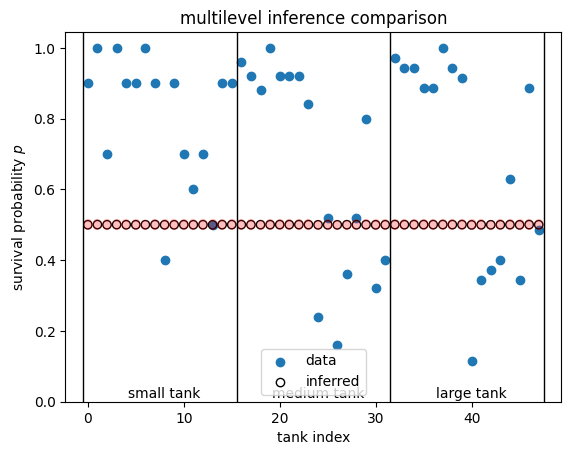

In [7]:
def model_m13_1(data, training=False):
    num_tanks = 48#data["tank"].shape[0]
    a = pyro.sample("a", Normal(0, 0.01).expand([num_tanks]).to_event(0))
    p = torch.sigmoid(a)
    if training:
        pyro.sample("S", Binomial(data["N"], p), obs=data["S"])
    else:
        return pyro.sample("S", Binomial(data["N"], p))
m13_1 = train_nuts(model_m13_1, data, 200, 200)
m13_1.summary()
plot_tank(m13_1)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 1000/1000 [00:32, 31.02it/s, step size=4.72e-02, acc. prob=0.660]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]      2.73      1.42      2.41      0.51      4.79    155.14      1.01
      a[1]     85.84     63.62     70.57      3.50    181.18     87.10      1.01
      a[2]      0.88      0.71      0.84     -0.14      2.15    269.14      1.01
      a[3]     75.05     56.44     61.29      2.40    157.28    151.29      1.00
      a[4]      2.60      1.23      2.40      0.41      4.49    259.85      1.01
      a[5]      2.56      1.34      2.31      0.72      4.46     99.42      1.01
      a[6]     85.98     64.31     72.51      2.73    178.68    168.52      1.00
      a[7]      2.78      1.43      2.54      0.80      5.08    156.45      1.00
      a[8]     -0.44      0.66     -0.39     -1.55      0.64    260.58      1.00
      a[9]      2.70      1.22      2.54      0.97      4.75    169.18      1.00
     a[10]      0.85      0.69      0.85     -0.29      2.00    341.20      1.00
     a[11]      0.50      0

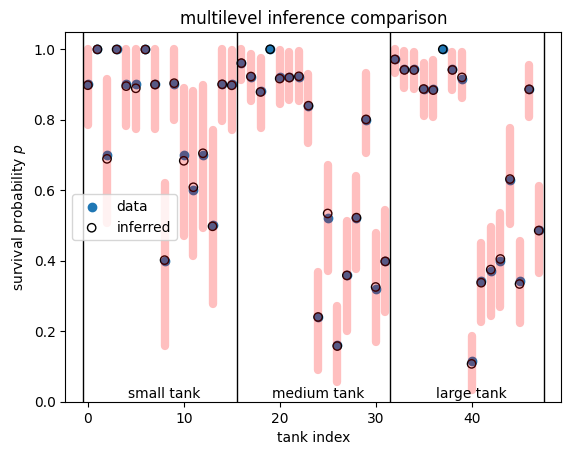

In [8]:
def model_m13_1(data, training=False):
    num_tanks = 48#data["tank"].shape[0]
    a = pyro.sample("a", Normal(0, 100).expand([num_tanks]).to_event(0))
    p = torch.sigmoid(a)
    if training:
        pyro.sample("S", Binomial(data["N"], p), obs=data["S"])
    else:
        return pyro.sample("S", Binomial(data["N"], p))
m13_1 = train_nuts(model_m13_1, data, 500, 500)
m13_1.summary()
plot_tank(m13_1)

/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Normal(0, 100)')

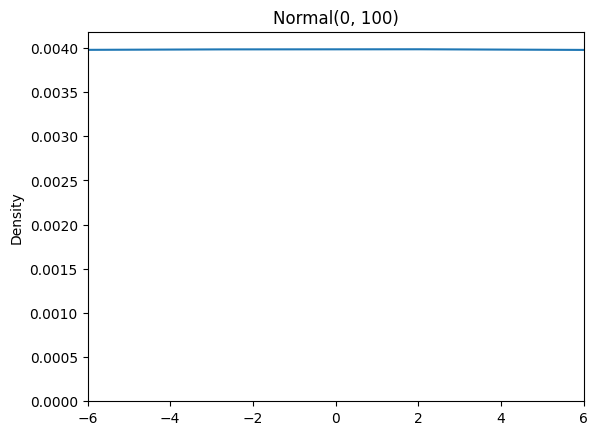

In [9]:
y = Normal(0, 100).sample([100000])
sns.kdeplot(y)
plt.xlim(-6, 6)
plt.title(r"Normal(0, 100)")

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 400/400 [00:01, 369.66it/s, step size=5.26e-01, acc. prob=0.869]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]      1.69      0.72      1.63      0.57      2.86    332.44      1.00
      a[1]      2.47      0.91      2.42      1.30      4.27    268.16      1.00
      a[2]      0.75      0.71      0.68     -0.34      1.87    123.26      1.00
      a[3]      2.38      0.88      2.37      1.03      3.82    111.16      1.00
      a[4]      1.70      0.81      1.64      0.33      3.00    514.82      1.00
      a[5]      1.71      0.89      1.64      0.00      2.92    267.13      1.00
      a[6]      2.44      0.89      2.41      1.02      3.75     85.25      1.00
      a[7]      1.70      0.73      1.70      0.50      2.92    372.74      1.00
      a[8]     -0.39      0.66     -0.36     -1.50      0.66    185.52      0.99
      a[9]      1.75      0.79      1.67      0.68      3.24    229.35      1.00
     a[10]      0.77      0.65      0.75     -0.31      1.65    297.50      1.00
     a[11]      0.37      0

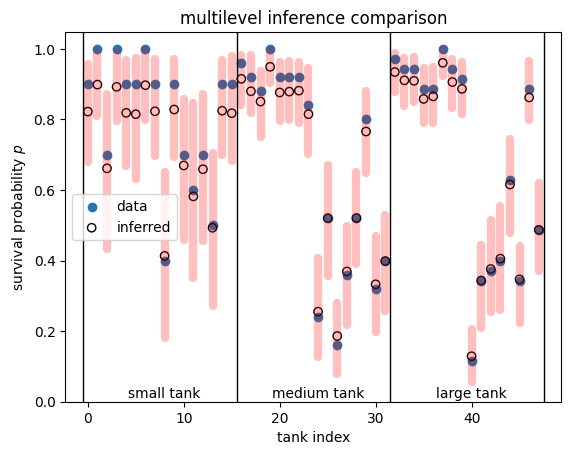

In [10]:
def model_m13_1(data, training=False):
    num_tanks = 48#data["tank"].shape[0]
    a = pyro.sample("a", Normal(0, 1.5).expand([num_tanks]).to_event(0))
    p = torch.sigmoid(a)
    if training:
        pyro.sample("S", Binomial(data["N"], p), obs=data["S"])
    else:
        return pyro.sample("S", Binomial(data["N"], p))
m13_1 = train_nuts(model_m13_1, data, 200, 200)
m13_1.summary()
plot_tank(m13_1)

Now, let's do a multilevel model which adaptively pools information across tanks.

$$\begin{align*}
S_i &\sim \text{Binomial}(N_i, p_i) \\
p_i &= \sigma(\alpha_\text{tank[i]}) \\
\alpha_j &\sim \text{Normal}(\bar{\alpha}, \sigma);\qquad j=0, \cdots, 47 \\
\bar{\alpha} &\sim \text{Normal}(0, 1.5) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}$$

Earlier the parameters of priors were fixed. 

A new model inside it. Because it looks like likelihood if $\alpha_j$ was data then it would have been like likelihood term. 

$\bar{\alpha}$ and $\sigma$ are typically referred to as _hyperparameters_, and their priors as _hyperpriors_



In [11]:
def model_m13_2(data, training=False):
    num_tanks = data["tank"].shape[0]
    abar = pyro.sample("abar", Normal(0., 1.5))
    sigma = pyro.sample("sigma", Exponential(1.))
    a = pyro.sample("a", Normal(abar, sigma).expand([num_tanks]).to_event(0))
    p = torch.sigmoid(a)
    if training:
        pyro.sample("S", Binomial(data["N"], p), obs=data["S"])
    else:
        pyro.sample("S", Binomial(data["N"], p))

In [12]:
m13_2 = train_nuts(model_m13_2, data, 300, 2000)
m13_2.summary()

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 2300/2300 [00:11, 202.69it/s, step size=4.25e-01, acc. prob=0.890]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]      2.17      0.87      2.10      0.82      3.55   2217.97      1.00
      a[1]      3.06      1.08      2.94      1.40      4.78   1891.10      1.00
      a[2]      1.03      0.69      1.00     -0.13      2.08   1863.21      1.00
      a[3]      3.03      1.10      2.96      1.40      5.00   2313.63      1.00
      a[4]      2.12      0.87      2.07      0.63      3.44   2260.47      1.00
      a[5]      2.17      0.87      2.13      0.75      3.52   1843.05      1.00
      a[6]      3.03      1.10      2.91      1.27      4.85   2230.91      1.00
      a[7]      2.12      0.88      2.07      0.78      3.60   2239.52      1.00
      a[8]     -0.17      0.60     -0.18     -1.20      0.75   2281.93      1.00
      a[9]      2.13      0.87      2.05      0.85      3.56   1800.54      1.00
     a[10]      0.99      0.71      0.95     -0.14      2.11   1915.47      1.00
     a[11]      0.56      0

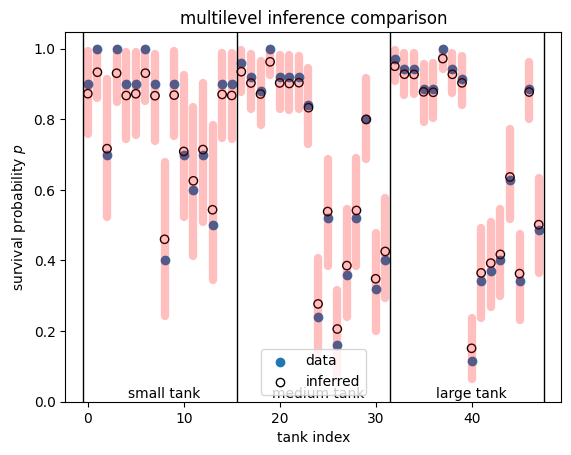

In [13]:
# https://python.arviz.org/en/stable/api/generated/arviz.InferenceData.add_groups.html
# https://forum.pyro.ai/t/evaluation-of-generative-model-predictive-likelihood-and-point-predictions/3830/12
# https://python.arviz.org/en/latest/schema/PyMC3_schema_example.html
# https://python.arviz.org/en/latest/schema/schema.html
# https://python.arviz.org/en/stable/getting_started/CreatingInferenceData.html
plot_tank(m13_2)

Let us compare the WAIC for each of these models (the first output is the WAIC itself, the second is the "effective # of parameters"). We can see that the multi-level model is clearly "better" because of the lower WAIC, and that the eff. # of parameters for both models (\~24) is significantly smaller than the actual # of parameters (\~50). This is because the regularizing prior essentially limits the degrees of freedom.

In [14]:
# multilevel model
S = Predictive(model_m13_2, m13_2.get_samples(), return_sites=("S",))(data)["S"]
p = torch.sigmoid(m13_2.get_samples()["a"])
log_p = Binomial(data["N"], p).log_prob(S)
waic(log_p, pointwise=False)

(tensor(203.5676, dtype=torch.float64), tensor(24.6111, dtype=torch.float64))

In [15]:
# single-level model
S = Predictive(model_m13_1, m13_1.get_samples(), return_sites=("S",))(data)["S"]
p = torch.sigmoid(m13_1.get_samples()["a"])
log_p = Binomial(data["N"], p).log_prob(S)
waic(log_p, pointwise=False)

(tensor(210.4841, dtype=torch.float64), tensor(23.5159, dtype=torch.float64))

If we look at how the inferred values of the survival deviate from the sample values, we notice two things:
1. All the inferred values are shifted towards the mean value of $\bar{p} = \sigma(\bar{\alpha})$. This is known as "concentration of measure"
2. The inferred survival rates in larger tanks are closer to the empirical values than the rates of smaller tanks. This is likely because the larger sample size reduces uncertainty.

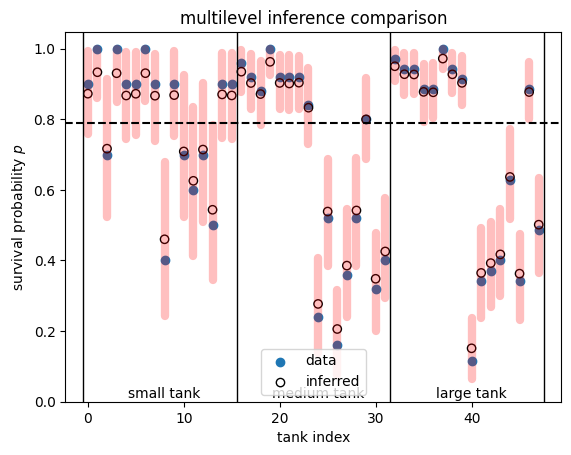

In [16]:
samples = m13_2.get_samples()
plot_tank(m13_2)

abar = torch.sigmoid(samples["abar"]).mean()
plt.axhline(abar, color="black", linestyle="--")
plt.title("multilevel inference comparison")
plt.show()

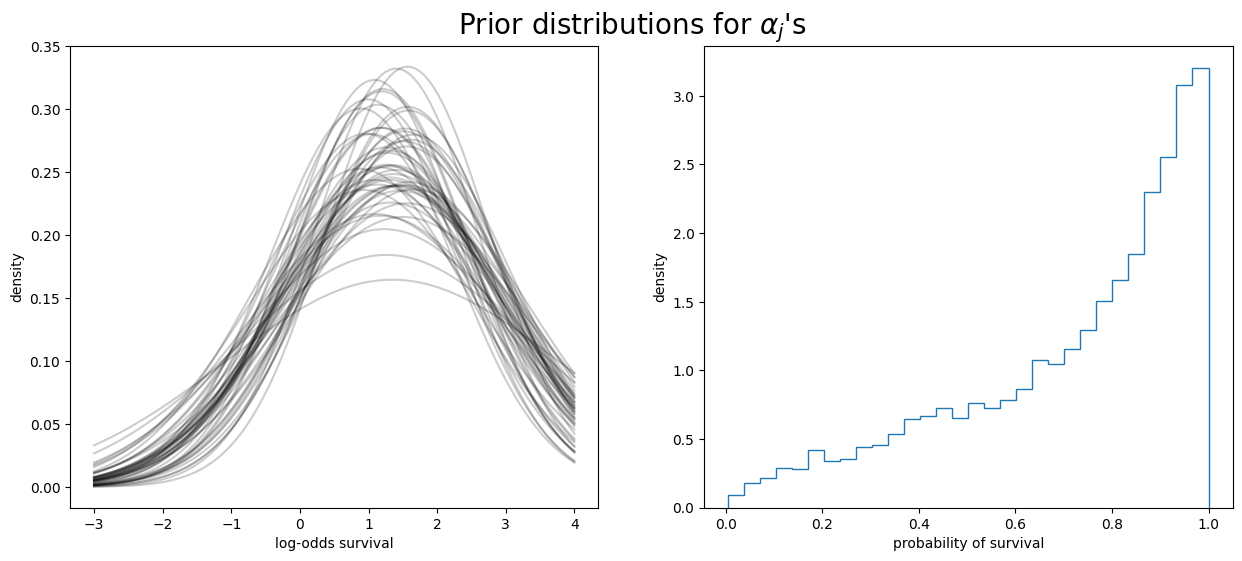

In [17]:
abar, s = [samples[k] for k in ("abar", "sigma")]
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
# Samples from the prior for the alpha_j's
plt.sca(axes[0])
x = torch.linspace(-3, 4, 100)
for i in range(50):
    y = Normal(abar[i], s[i]).log_prob(x).exp()
    plt.plot(x, y, color="black", alpha=0.2)
plt.xlabel("log-odds survival")
plt.ylabel("density")
# resample from prior to get survival probability
plt.sca(axes[1])
a = Normal(abar, s).sample([4]).flatten() # 8000 new samples
p = torch.sigmoid(a)
plt.hist(p, bins=30, density=True, histtype="step")
plt.xlabel("probability of survival")
plt.ylabel("density")
plt.suptitle(r"Prior distributions for $\alpha_j$'s", y=0.94, fontsize=20)
plt.show()

### Code 13.7 - 13.20
We will now explore how changing the pooling of data (complete pooling, no pooling, partial pooling) affects the estimates of our inferential parameters. We will run a simulation to generate a dataset, then try to recover the parameters used to generate the data.

In [18]:
# set simulation parameters
a_bar = 1.5
sigma = 1.5
n_ponds = 60
Ni = np.array(list(it.chain(*[15*[n] for n in (5, 10, 25, 35)])))
# run sim
a_pond = stats.norm(loc=a_bar, scale=sigma).rvs(size=n_ponds)
p = torch.sigmoid(tt(a_pond)).numpy()
df = pd.DataFrame({"Ni": Ni, "true_a": a_pond})
df["Si"] = stats.binom(n=Ni, p=p).rvs()
df.head()

,Ni,true_a,Si
0,5,2.084619,4
1,5,0.154551,2
2,5,4.218060,5
3,5,1.565127,4
4,5,1.245951,4


Now we will start computing estimates of the model parameters

In [19]:
df["p_nopool"] = df["Si"]/df["Ni"] # estimates without pooling

In [20]:
data = dict(
    num_ponds=len(df),
    Ni=tt(df["Ni"].values).long(),
    Si=tt(df["Si"].values).double(),
)

In [21]:
# partial pooling model
def model_m13_3(data, training=False):
    num_ponds = data["num_ponds"]
    abar = pyro.sample("abar", Normal(0., 1.5))
    sigma = pyro.sample("sigma", Exponential(1.))
    a = pyro.sample("a", Normal(abar, sigma).expand([num_ponds]).to_event(0))
    p = torch.sigmoid(a)
    if training:
        pyro.sample("Si", Binomial(data["Ni"], p), obs=data["Si"])
    else:
        pyro.sample("Si", Binomial(data["Ni"], p))

In [22]:
m13_3 = train_nuts(model_m13_3, data, 500, 2000)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 2500/2500 [00:15, 165.74it/s, step size=3.24e-01, acc. prob=0.929]


In [23]:
m13_3.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]      1.56      0.91      1.53      0.06      2.94   4986.67      1.00
      a[1]      0.18      0.81      0.19     -1.24      1.42   4519.74      1.00
      a[2]      2.51      1.08      2.46      0.71      4.23   2866.07      1.00
      a[3]      1.58      0.90      1.54      0.09      3.08   3726.98      1.00
      a[4]      1.57      0.91      1.53      0.03      2.96   4098.52      1.00
      a[5]      2.51      1.04      2.46      0.81      4.17   4192.75      1.00
      a[6]      0.82      0.84      0.79     -0.55      2.14   5606.36      1.00
      a[7]      2.55      1.12      2.48      0.69      4.31   3914.56      1.00
      a[8]      1.57      0.90      1.54      0.20      3.03   4040.89      1.00
      a[9]      2.51      1.09      2.40      0.79      4.27   3121.07      1.00
     a[10]      1.57      0.91      1.53      0.14      3.10   3162.66      1.00
     a[11]      2.51      1

In [24]:
df["p_partpool"] = torch.sigmoid(m13_3.get_samples()["a"]).mean(dim=0).numpy()
df["p_true"] = torch.sigmoid(tt(df["true_a"].values)).numpy()

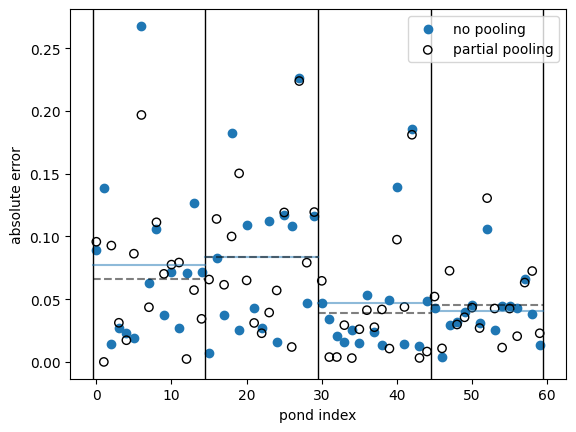

In [25]:
# calculate errors between estimates
nopool_error = np.abs(df["p_nopool"] - df["p_true"]).values
partpool_error = np.abs(df["p_partpool"] - df["p_true"]).values
x = df.index.values
plt.scatter(x, nopool_error, label="no pooling", color="C0")
plt.scatter(x, partpool_error, label="partial pooling", facecolor="none", edgecolor="black")
for i in range(5):
    plt.axvline(15*i-0.5, color="black", linewidth=1)
for i in range(4):
    xmin, xmax = 15*i, 15*(i+1)
    x = [xmin-0.5, xmax-0.5]
    nopool_mean = nopool_error[xmin:xmax].mean()
    partpool_mean = partpool_error[xmin:xmax].mean()
    plt.plot(x, 2*[nopool_mean], color="C0", alpha=0.5)
    plt.plot(x, 2*[partpool_mean], color="black", alpha=0.5, linestyle="--")
plt.xlabel("pond index")
plt.ylabel("absolute error")
plt.legend(loc="upper right")
plt.show()

We can see from the above (absolute) residuals that the partial pooling model has lower error on average than the model with no pooling

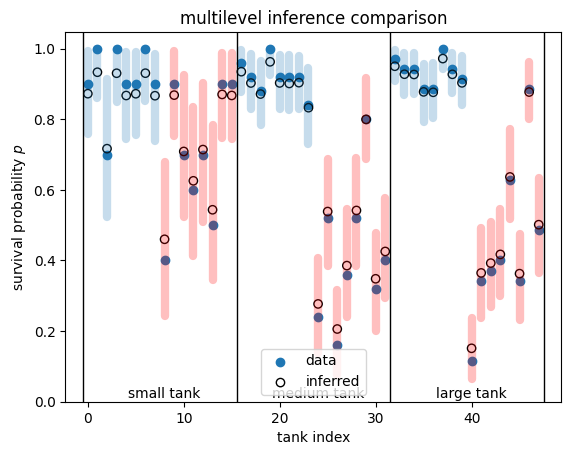

In [26]:
PREDATOR_COLORS = ["C0" if p == "no" else "red" for p in tadpole_df['pred'].values]
plot_tank(m13_2, colors=PREDATOR_COLORS)

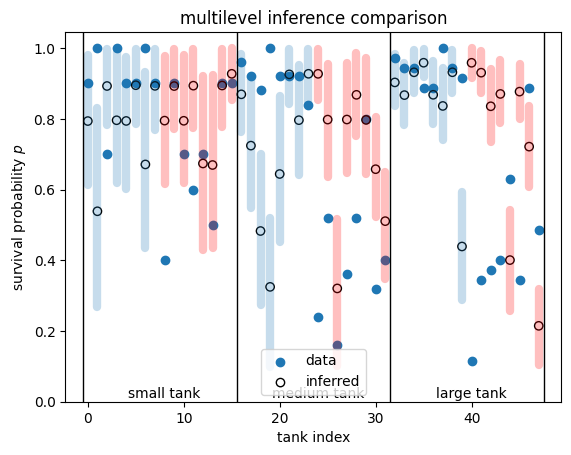

In [27]:
PREDATOR_COLORS = ["C0" if p == "no" else "red" for p in tadpole_df['pred'].values]
plot_tank(m13_3, colors=PREDATOR_COLORS)

#### HW

$$\begin{align*}
S_i &\sim \text{Binomial}(N_i, p_i) \\
p_i &= \sigma(\alpha_\text{tank[i]} + \beta_P P_i)  \\
\beta_P &\sim \text{Normal}(0, 0.5)\\
\alpha_j &\sim \text{Normal}(\bar{\alpha}, \sigma);\qquad j=0, \cdots, 47 \\
\bar{\alpha} &\sim \text{Normal}(0, 1.5) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}$$


Conditioning on predators also gives very similar predictions. you can check with calibaration plot type of plots. One x axis, do not condition on predators and on y axis condition on predators.  Posterior of new coefficient will be negative. 

Add density D and size G to the model.

$$\begin{align*}
S_i &\sim \text{Binomial}(N_i, p_i) \\
p_i &= \sigma(\alpha_\text{tank[i]} + \beta_P P_i + \beta_D D_i + \beta_G G_i)  \\
\beta_P &\sim \text{Normal}(0, 0.5)\\
\beta_D &\sim \text{Normal}(0, \_)\\
\beta_G &\sim \text{Normal}(0, \_)\\
\alpha_j &\sim \text{Normal}(\bar{\alpha}, \sigma);\qquad j=0, \cdots, 47 \\
\bar{\alpha} &\sim \text{Normal}(0, 1.5) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}$$